# Simulations of RK Nets

#### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from prettytable import PrettyTable
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

#### Choose dataset, neural network, loss function, training method and their hyperparameters

In [2]:
# data
data_example = 'donut_multiclass'  # dataset (options: 'donut_1D', 'donut_2D', 'squares', 'spiral', 'donut_highD', 'squares_highD', 'spiral_3D', 'donut_multiclass', 'squares_multiclass')
d = 2                           # dimension of data space, has to be None except for 'donut_highD', 'squares_highD', 'donut_multiclass', 'squares_multiclass'
K = 3                           # number of classes, has to be None except for 'donut_multiclass'
N = 1500                        # number of training samples
V = 1500                        # number of validation samples
binary = False                  # treat as binary classification (i.e. K = 1 if True), has to be False for 'donut_multiclass' and 'squares_multiclass'

# network
net_architecture = 'EulerNet'   # network architecture (options: 'StandardNet', 'EulerNet', 'RK4Net')
d_hat =  16                     # dimension of the feature space (here constant over all layers) (e.g.: 2, 3, 16, 100, 300)
L = 40                          # number of layers (e.g.: 1, 4, 5, 10, 20, 100, 300)
act_function = 'tanh'           # activation function(options: 'tanh', 'sigmoid', 'relu', 'softplus')
fill_zeros = False              # space augmentation by padding with zeros or by adding random intialized and not trained layer without bias
classifier_mode = 'train'       # train or fix classifier (options: 'train', 'fix')

# training
loss_criterion = 'cross_entropy'# loss function (options: 'mse', 'cross_entropy')
batch_size = 5                  # batch size (e.g.: 5, 16)
optim_method = 'adam'           # optimization method (options: 'sgd', 'adagrad', 'adam', 'adadelta')
if optim_method == 'sgd':
    lr = 1e-1                   # learning rate (e.g.: 1e-1, 1e-3)
    momentum = 0.9              # momentum (e.g.: 0.0, 0.9)
else:
    lr = None
    momentum = None
weight_decay = 0.0              # weight decay for regularization (e.g.: 0.0, 1e-2, 1e-1)
max_epochs = 40                 # maximum number of epochs (e.g.: 30, 40, 80)
tol = 5e-2                      # minimum decrease of performance (measured by validation cost) for early stopping to avoid overfitting (e.g.: 5e-2, 1e5 to avoid early stopping)

# check inputs
assert isinstance(data_example, str), 'name of dataset has to be a string'
assert (isinstance(d, int) and d >= 1) or d == None, 'dimension of data space has to be an integer greater than or equal to 1'
assert (isinstance(K, int) and K >= 1) or K == None, 'number of classes has to be an integer greater than or equal to 1'
assert isinstance(N, int) and N >= 1 and isinstance(V, int) and V >= 1, 'number of training and validation samples has to be an integer greater than or equal to 1'
assert isinstance(binary, bool), 'decision for label representation as in binary or general classification has to be of type boolean'
assert isinstance(net_architecture, str), 'name of network architecture has to be a string'
assert isinstance(d_hat, int) and d_hat >= 1, 'dimension of feature space has to be an integer greater than or equal to 1'
assert isinstance(L, int) and L >= 1, 'number of layers has to be an integer greater than or equal to 1'
assert isinstance(act_function, str), 'name of activation function has to be a string'
assert classifier_mode == 'train' or classifier_mode == 'fix', 'parameters of linear classifier has to be specified by either \'train\' or \'fix\''
assert isinstance(loss_criterion, str), 'name of loss function has to be a string'
assert isinstance(batch_size, int) and batch_size >= 1, 'batch size has to be an integer greater than or equal to 1'
assert isinstance(optim_method, str), 'name of optimization method has to be a string'
assert (isinstance(lr, float) and lr > 0) or lr == None, 'learning rate has to be of type float greater than 0'
assert isinstance(weight_decay, float) and weight_decay >= 0, 'weight decay has to be of type float greater than or equal to 0'
assert (isinstance(momentum, float) and momentum >= 0) or momentum == None, 'weight decay has to be of type float greater than or equal to 0'
assert isinstance(max_epochs, int) and max_epochs >= 1, 'number of epochs has to be an integer greater than or equal to 1'
assert isinstance(tol, float), 'treshold for early stopping has to be of type float'

#### Get data

/mnt/c/Users/Elisa/Desktop/Paper/Code_Revision/toydata_multiclass.py:52: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  ind_class = ((R >= tresholds[i]) * (R < tresholds[i + 1])).nonzero()[:, 0]


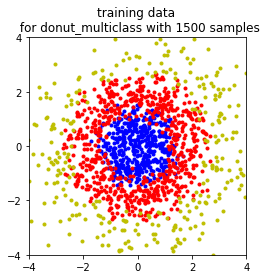

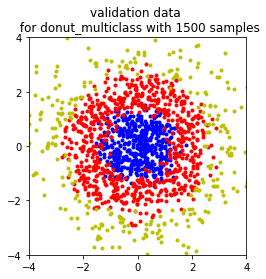

In [3]:
import toydata
import toydata_highD
import toydata_multiclass
import plot

# generate training and validation data with labels
if data_example == 'donut_1D':
    X_train, C_train, X_val, C_val, d, K = toydata.donut_1D(N, V, binary)
elif data_example == 'donut_2D':
    X_train, C_train, X_val, C_val, d, K = toydata.donut_2D(N, V, binary)
elif data_example == 'squares':
    X_train, C_train, X_val, C_val, d, K = toydata.squares(N, V, binary)
elif data_example == 'spiral':
    X_train, C_train, X_val, C_val, d, K = toydata.spiral(N, V, binary)
elif data_example == 'donut_highD':
    X_train, C_train, X_val, C_val, d, K = toydata_highD.donut_highD(N, V, binary, d)
elif data_example == 'squares_highD':
    X_train, C_train, X_val, C_val, d, K = toydata_highD.squares_highD(N, V, binary, d)
elif data_example == 'spiral_3D':
    X_train, C_train, X_val, C_val, d, K = toydata_highD.spiral_3D(N, V, binary)
elif data_example == 'donut_multiclass':
    X_train, C_train, X_val, C_val, d, K = toydata_multiclass.donut_multiclass(N, V, d, K)
elif data_example == 'squares_multiclass':
    X_train, C_train, X_val, C_val, d, K = toydata_multiclass.squares_multiclass(N, V, d)
else:
    raise Exception('invalid dataset')

assert d_hat >= d, 'dimension of feature space should be greater than or equal to dimension of input space'

if d == 2 or d == 3:
    # plot training data
    plot.plot_multiclass_toydata(X_train, C_train)
    plt.title('training data \n for %s with %d samples' % (data_example, N))
    plt.show()

    # plot validation data
    plot.plot_multiclass_toydata(X_val, C_val)
    plt.title('validation data \n for %s with %d samples' % (data_example, V))
    plt.show()

#### Construct fully-connected network

In [4]:
import NN

# create network
if net_architecture == 'StandardNet':
    net = NN.StandardNet(d, d_hat, K, L, act_function)
elif net_architecture == 'EulerNet':
    net = NN.EulerNet(d, d_hat, K, L, act_function)
elif net_architecture == 'RK4Net':
    net = NN.RK4Net(d, d_hat, K, L, act_function)
else:
    raise Exception('invalid network architecture')

# space augmentation by padding with zeros
if fill_zeros:
    trans_matrix = torch.zeros(d_hat, d)
    trans_matrix[:d, :] = torch.eye(d)
    net.layers[0].weight = nn.Parameter(trans_matrix)
net.layers[0].weight.requires_grad_(False)              # input layer not trained, i.e. weight is fixed

if classifier_mode == 'fix':
    # determine classifier weight and bias by uncommenting the following lines or use random initialization
    # note: the entries of classifier weight have great impact on the performance of the model (e.g. too small or too large numbers do not work well)
    ###net.classifier.weight = nn.Parameter(torch.full((K, d_hat), 1))  
    ###net.classifier.bias = nn.Parameter(torch.zeros(K))
    # disable training of classifier weight and bias
    net.classifier.weight.requires_grad_(False)          
    net.classifier.bias.requires_grad_(False)

# view network architecture
print('network architecture:')
print(net, '\n')
params = list(net.parameters())    
    
# total number of neurons   
num_neurons = d + d_hat * L
print('total number of neurons in network:              ', num_neurons)
    
# total number of parameters
num_params = sum(p.numel() for p in net.parameters())
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('total number of parameters in network:           ', num_params)
print('total number of trainable parameters in network: ', num_trainable_params)

network architecture:
EulerNet(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=16, bias=False)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=16, bias=True)
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): Linear(in_features=16, out_features=16, bias=True)
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): Linear(in_features=16, out_features=16, bias=True)
    (10): Linear(in_features=16, out_features=16, bias=True)
    (11): Linear(in_features=16, out_features=16, bias=True)
    (12): Linear(in_features=16, out_features=16, bias=True)
    (13): Linear(in_features=16, out_features=16, bias=True)
    (14): Linear(in_features=16, out_features=16, bias=True)
    (15): Linear(in_features=16, out_fe

#### Create dataloader

In [5]:
import dataset

# create datasets
TrainSet = dataset.toydataset(X_train, C_train)
ValSet = dataset.toydataset(X_val,C_val)

# create dataloaders for building batches
TrainLoader = DataLoader(TrainSet, batch_size, shuffle=True) 
ValLoader = DataLoader(ValSet, batch_size, shuffle=True)

#### Get prediction for validation data before training

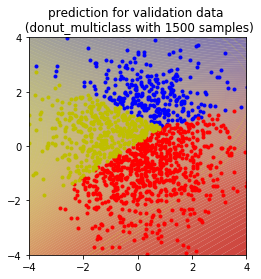

sanity check - prediction mean should be roughly 0.3333 and prediction variance relatively small
prediction mean:      tensor([0.2758, 0.3913, 0.3329])
prediction variance:  tensor([0.1379, 0.1957, 0.0914])


In [6]:
import prediction

# prediction of validation set before training
X_predicted, _, _ = net(X_val)
C_pred = prediction.pred(X_predicted)

if d == 2 or d == 3:
    # plot prediction
    plot.plot_multiclass_toydata(X_val,C_pred)
    if d == 2:
        plot.plot_multiclass_prediction(net)
    plt.title('prediction for validation data \n (%s with %d samples)' % (data_example, V))
    plt.show()

# do sanity check
print('sanity check - prediction mean should be roughly %.4f and prediction variance relatively small' % (1/2 if K==1 else 1/K))
print('prediction mean:     ', X_predicted.mean(axis=0).data)
print('prediction variance: ', X_predicted.std(axis=0).data)

#### Train neural network

In [7]:
import optimization

# print training loss and gradient every print_batch batches (e.g. len(TrainLoader) for printing only once at the end of each epoch)
print_batch = len(TrainLoader) 

all_data = [X_train, C_train, X_val, C_val]

# training function 
# prints [epoch, i_batch] training loss: running_loss    gradient: running_gradient 
cost_train, acc_train, cost_val, acc_val = optimization.train(net, TrainLoader, all_data, optim_method, lr, 
                                                          weight_decay, momentum, loss_criterion, max_epochs, tol, 
                                                          print_batch)

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


[1,   300] training loss: 1.045    gradient: 3.051
[2,   300] training loss: 0.932    gradient: 3.441
[3,   300] training loss: 0.792    gradient: 3.768
[4,   300] training loss: 0.621    gradient: 4.339
[5,   300] training loss: 0.490    gradient: 5.215
[6,   300] training loss: 0.407    gradient: 6.286
[7,   300] training loss: 0.360    gradient: 7.092
[8,   300] training loss: 0.335    gradient: 7.927
[9,   300] training loss: 0.318    gradient: 8.046
[10,   300] training loss: 0.313    gradient: 8.755
[11,   300] training loss: 0.303    gradient: 8.948
[12,   300] training loss: 0.298    gradient: 8.881
[13,   300] training loss: 0.292    gradient: 8.987
[14,   300] training loss: 0.290    gradient: 9.321
[15,   300] training loss: 0.288    gradient: 9.520
[16,   300] training loss: 0.288    gradient: 9.153
[17,   300] training loss: 0.286    gradient: 9.211
[18,   300] training loss: 0.289    gradient: 9.617
[19,   300] training loss: 0.287    gradient: 9.029
[20,   300] training 

#### Get intial and final cost and accuracy for training and validation data

In [8]:
# table for cost
print('statistics of cost')
t = PrettyTable(['', 'before training', 'after training'])
t.add_row(['training set', '%.3f' % cost_train[0], '%.3f' % cost_train[-1]])
t.add_row(['validation set', '%.3f' % cost_val[0], '%.3f' % cost_val[-1]])
print(t)

# table for accuracy
print('\n statistics of accuracy')
t = PrettyTable(['', 'before training', 'after training'])
t.add_row(['training set', '%d %%' % acc_train[0], '%d %%' % acc_train[-1]])
t.add_row(['validation set', '%d %%' % acc_val[0], '%d %%' % acc_val[-1]])
print(t)

statistics of cost
+----------------+-----------------+----------------+
|                | before training | after training |
+----------------+-----------------+----------------+
|  training set  |      1.220      |     0.255      |
| validation set |      1.241      |     0.257      |
+----------------+-----------------+----------------+

 statistics of accuracy
+----------------+-----------------+----------------+
|                | before training | after training |
+----------------+-----------------+----------------+
|  training set  |       31 %      |      89 %      |
| validation set |       28 %      |      88 %      |
+----------------+-----------------+----------------+


#### Plot training and validation cost and accuracy over training period

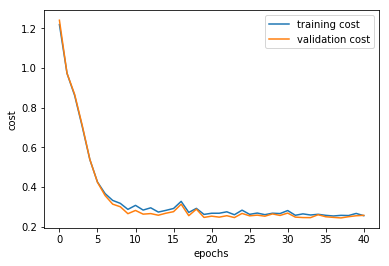

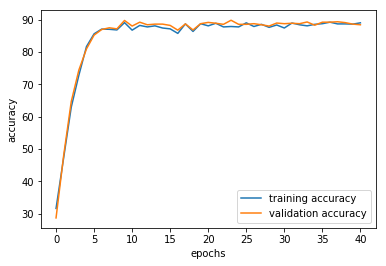

In [9]:
# plot cost
fig = plt.figure()
plt.plot(range(len(cost_train)), cost_train, label = 'training cost')
plt.plot(range(len(cost_val)), cost_val, label = 'validation cost')
plt.legend()
plt.ylabel('cost')
plt.xlabel('epochs')
plt.show()

# plot accurracy
fig = plt.figure()
plt.plot(range(len(acc_train)), acc_train, label = 'training accuracy')
plt.plot(range(len(acc_val)), acc_val, label = 'validation accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

#### Get prediction for validation data after training

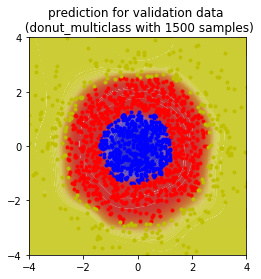

sanity check - prediction mean depends on number of samples of each class and prediction variance relatively large, if model classifies well
prediction mean:      tensor([0.3260, 0.4623, 0.2117])
prediction variance:  tensor([0.4172, 0.4119, 0.3654])


In [10]:
# prediction of validation set after training
X_predicted, _, X_transformed = net(X_val)
C_pred = prediction.pred(X_predicted)

if d == 2 or d == 3:
    # plot prediction
    plot.plot_multiclass_toydata(X_val, C_pred)
    if d == 2:
        plot.plot_multiclass_prediction(net)
    plt.title('prediction for validation data \n (%s with %d samples)' % (data_example, V))
    plt.show()

# do sanity check
print('sanity check - prediction mean depends on number of samples of each class and prediction variance relatively large, if model classifies well')
print('prediction mean:     ', X_predicted.mean(axis=0).data)
print('prediction variance: ', X_predicted.std(axis=0).data)

#### Plot transformation of features for validation data

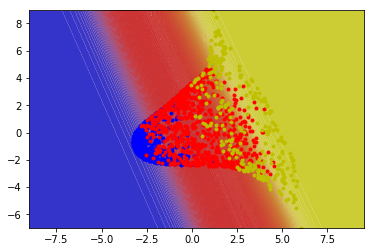

In [11]:
# 2D or 3D plot (options: 2, 3)
dim_plot = 2 

# dimensionality reduction: do principal component analysis, otherwise choose features at random (here first 2 or 3)
dim_reduction = True
# keep axes constant, otherwise let axes vary  
constant_axes = True
# if 2D: plot background only in output or in all layers (requires constant axes)
if d_hat == 2 or (dim_plot == 2 and dim_reduction == True):
    if constant_axes == True:
        output_layer = False
    else:
        output_layer = True
else:
    output_layer = None
# display sequence of plots or only last plot, i.e. output layer
show_output = True
    
# plot transformation 
plot.plot_multiclass_transformation(X_transformed, C_val, dim_plot, dim_reduction, constant_axes, 
                        output_layer=output_layer, net=net, show_output=show_output)
plt.show()

# save transformation as video
if not os.path.exists('notebook_experiments'):
    os.makedirs('notebook_experiments')
plot.plot_multiclass_transformation(X_transformed, C_val, dim_plot, dim_reduction, constant_axes, 
                        output_layer=output_layer, net=net, save='notebook_experiments/transformation')

#### Plot trajectories for a subset of validation data (small dots represent input and large dots represent output)

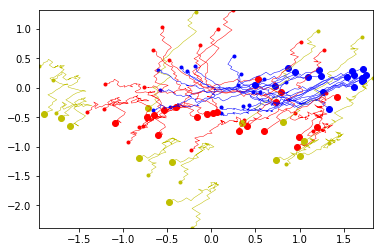

In [12]:
# choose only some data points to not overcrowd the plot
choose_data = np.random.choice(V, 50)       

# plot trajectories
plot.plot_multiclass_trajectories(X_transformed[choose_data, :, :], C_val[choose_data,:], dim_plot, 
                                  show_output=show_output)
plt.show()

# save trajectories as video
plot.plot_multiclass_trajectories(X_transformed[choose_data, :, :], C_val[choose_data,:], dim_plot, 
                                  save='notebook_experiments/trajectories')